In [22]:
# Imports
import numpy as np
import pandas as pd
import os
from sklearn import feature_extraction, linear_model, model_selection, preprocessing, metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import string
import re
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

# Problem Description

### Problem Description
The goal of this project is to classify tweets as to whether or not they are referring to or reporting a real disaster or not. The ability to parse through a large set of tweets and determine if a real disaster is occuring would be a helpful tool for reporters to determine whether or not an event is relevant to report on. 

To develop this model, we will need to use Natural Language Processing (NLP) techniques to sort through the text in each tweet. NLP techniques can include the weighting of the frequency of each word or weighting the pairings of certain words together. They can also include having a set of exclude words. Having words such as "the" or "an" in a tweet (for the English language) should not be weighted as they are very common words that would occur in both disaster and non-disaster tweets. 

The Kaggle competition is cited below in [1]. The competition also provides a getting started tutorial [2] which I referenced while implementing this code. 


[1] Addison Howard, devrishi, Phil Culliton, Yufeng Guo. (2019). Natural Language Processing with Disaster Tweets. Kaggle. https://kaggle.com/competitions/nlp-getting-started

[2] https://www.kaggle.com/code/philculliton/nlp-getting-started-tutorial/notebook

### Data Description

**Size:** The training data is a 988 KB CSV and the testing data is a 421 KB CSV. This is a relatively small dataset. 

**Dimension:** There are 7613 training samples and 3263 testing samples. The text lengths range from 1 to 56 words per tweet in the training data (where a word is any character set separated by white space). The text lengths range from 1 to 34 words per tweet in the testing data. 

**Structure:** There are two files of relevance: a train and test CSV. The data is structured such that each row is a sample. Each row contains an ID (unique identifier) for the sample tweet, the actual text of the tweet, the location for where the tweet was sent (this may be blank), and a keyword if there is one within the tweet. The train data also has a target column which has a 1 for a real disaster or a 0 if it is not referencing a real disaster.

**Results:** The resulting predictions are evaluated by the F1 score, which is a harmonic mean between the precision and recall. 

# EDA

In [2]:
data_dir = "/kaggle/input/nlp-getting-started"
train_file = 'train.csv'
test_file = 'test.csv'
sample_file = 'sample_submission.csv'

raw_train_df = pd.read_csv(os.path.join(data_dir, train_file))
raw_test_df = pd.read_csv(os.path.join(data_dir, test_file))
sample_submission_df = pd.read_csv(os.path.join(data_dir, sample_file))

In [3]:
num_train_samples, num_columns = raw_train_df.shape
num_test_samples = raw_test_df.shape[0]
print(f"There are {num_train_samples} training samples.")
print(f"There are {num_test_samples} testing samples.")
print(f"Train data has {num_columns} columns: {raw_train_df.columns}")

There are 7613 training samples.
There are 3263 testing samples.
Train data has 5 columns: Index(['id', 'keyword', 'location', 'text', 'target'], dtype='object')


In [4]:
min_words = 10000
max_words = 0
for string_list in raw_train_df['text'].str.split("\s").values:
    word_count = len(string_list)
    if word_count > max_words:
        max_words = word_count
    if word_count < min_words:
        min_words = word_count
print(f"The minimum words in a tweet (words being determined by separation by whitespace) is: {min_words}")
print(f"The maximum words in a tweet (words being determined by separation by whitespace) is: {max_words}")

The minimum words in a tweet (words being determined by separation by whitespace) is: 1
The maximum words in a tweet (words being determined by separation by whitespace) is: 56


In [5]:
min_words = 10000
max_words = 0
for string_list in raw_test_df['text'].str.split("\s").values:
    word_count = len(string_list)
    if word_count > max_words:
        max_words = word_count
    if word_count < min_words:
        min_words = word_count
print(f"The minimum words in a tweet (words being determined by separation by whitespace) is: {min_words}")
print(f"The maximum words in a tweet (words being determined by separation by whitespace) is: {max_words}")

The minimum words in a tweet (words being determined by separation by whitespace) is: 1
The maximum words in a tweet (words being determined by separation by whitespace) is: 34


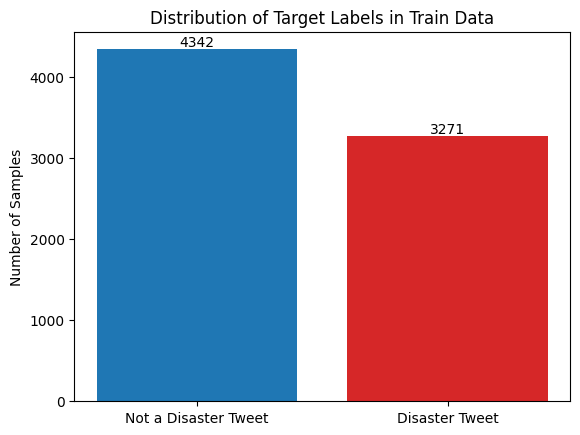

In [6]:
# Look at data label balance in the train data
num_disaster = raw_train_df[raw_train_df['target'] == 1].shape[0]
num_nondisaster = raw_train_df[raw_train_df['target'] == 0].shape[0]
bar_colors = ['tab:blue', 'tab:red']
bars = plt.bar(['Not a Disaster Tweet', 'Disaster Tweet'], [num_nondisaster, num_disaster], color=bar_colors)
plt.ylabel('Number of Samples')
plt.bar_label(bars)
plt.title('Distribution of Target Labels in Train Data')
plt.show()
plt.close()

The disparity in labels is not huge. If we see an issue with underpredicting disaster tweets, then we can perform data balancing in our train set. However, this will be used as a step towards improving a baseline model. 

There are 221 unique keywords
Let's build a word cloud to visualize the keywords based on how often they appear within the training tweets


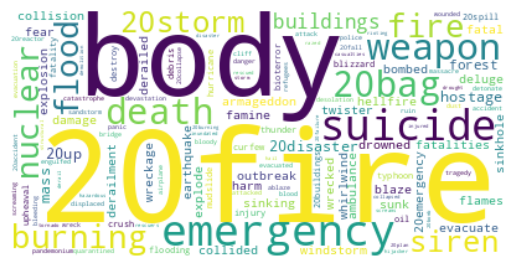

Note that the words starting with 20 are likely part of URLs in the dataset
We can see from the word cloud that the most common keywords in the train dataset appear to be fire, body, emergency, suicide, weapon, and death.


In [7]:
# Explore keywords
print(f"There are {len(set(raw_train_df['keyword'].dropna().values))} unique keywords")
print("Let's build a word cloud to visualize the keywords based on how often they appear within the training tweets")
text = " ".join(raw_train_df['keyword'].dropna().values)
word_cloud = WordCloud(collocations = False, background_color = 'white').generate(text)
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()
print("Note that the words starting with 20 are likely part of URLs in the dataset")
print("We can see from the word cloud that the most common keywords in the train dataset appear to be fire, body, emergency, suicide, weapon, and death.")

There are 3341 unique locations
Similar to the keywords, let's build a word cloud to visualize the locations based on how often they appear within the training tweets


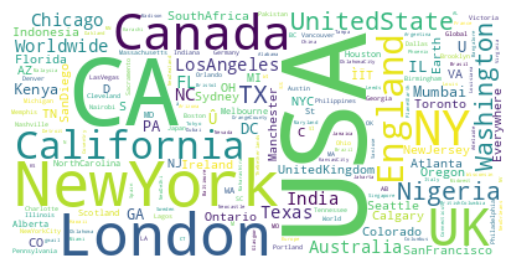

We see that some of the top locations for tweets are USA, New York, London, Candada, California, England, and Nigera.
It is possible that location could be a relevant feature in the model.


In [8]:
# Explore locations
print(f"There are {len(set(raw_train_df['location'].dropna().values))} unique locations")
print("Similar to the keywords, let's build a word cloud to visualize the locations based on how often they appear within the training tweets")
text = ", ".join(raw_train_df['location'].dropna().str.replace(" ", "").values)
word_cloud = WordCloud(collocations = False, background_color = 'white').generate(text)
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()
print("We see that some of the top locations for tweets are USA, New York, London, Candada, California, England, and Nigera.")
print("It is possible that location could be a relevant feature in the model.")

### Data Cleaning
We should remove extraneous information from the tweets, such as emojis, capitalization, URLs, and punctuation before approaching embedding of the word values.

In [9]:
def remove_emojis(series: pd.Series) -> pd.Series:
    return series.str.encode('ascii', 'ignore').str.decode('ascii')

def remove_links(series: pd.Series) -> pd.Series:
    for row_ix in series.index:
        series[row_ix] = re.sub(r'http\S+', '', series[row_ix], flags=re.MULTILINE)
    return series

# Clean the text column
clean_train_df = raw_train_df
clean_train_df['text'] = remove_links(remove_emojis(clean_train_df['text']))
# I did not remove punctuation or make the text lowercase here because this will be handled with the
# Text Vectorization layer in the models

In [10]:
# Split the data into train and validation sets before embeddings, so that
# we don't train the word embedding vectorizer on the validation data
X_train, X_val = model_selection.train_test_split(
    clean_train_df,
    test_size = .2,
    shuffle = True,
    random_state=42,
)

# Model Architecture

### Word Embeddings
I am adding a text vectorization layer to the beginning of the model. Note that this layer has a default setting of removing punctuation and making text lowercase. This layer will grab a vocabulary set from the training data and provide indexes for each vocab word. This vectorization with the indices will allow for the models to learn certain sequences of words that appear across tweets. We will also use the tf-idf output to help learn the frequencies of the terms. The tf-idf output refers to a Term Frequency and Inverse Document Frequency calculation. Term frequency is a measure of how many times the term appears within a tweet. The Inverse Document Frequency is a measure of how common the term is across all tweets. I used [4] as an example to follow for setting up the TextVectorization encoder. 


[4] https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization

In [33]:
# Set a vocab size (smaller is better for training time, can be changed if needed if accuracy is low)
VOCAB_SIZE = 1000
# Intitialize encoder with an output mdoe of tf-idf and given vocab size
encoder = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE, output_mode='tf-idf')
# Set encoding based on train data
encoder.adapt(X_train['text'].to_list())
# Test that output looks as expected
encoder(X_train['text'])

<tf.Tensor: shape=(6090, 1000), dtype=float32, numpy=
array([[42.10776  ,  0.       ,  0.       , ...,  0.       ,  0.       ,
         0.       ],
       [42.10776  ,  0.       ,  1.6730431, ...,  0.       ,  0.       ,
         0.       ],
       [42.10776  ,  1.4216704,  0.       , ...,  0.       ,  0.       ,
         0.       ],
       ...,
       [42.10776  ,  0.       ,  0.       , ...,  0.       ,  0.       ,
         0.       ],
       [15.790411 ,  0.       ,  3.3460863, ...,  0.       ,  0.       ,
         0.       ],
       [15.790411 ,  0.       ,  1.6730431, ...,  0.       ,  0.       ,
         0.       ]], dtype=float32)>

### Model Description

The first architecture uses a simple RNN layer. A simple RNN layer is fully connected. Since the size of the input data is relatively small (< 10000 samples and each entry is < 60 words), I think a fully connected RNN would be suitable for this problem. The final output layer should return a 0 or 1, and thus we will use a sigmoid activation function and perform an indicator activation with a 0.5.

In [34]:
def build_model(encoder):
    # Setup Sequential neural network
    model = models.Sequential(encoder)
    # Add embedding layer
    model.add(layers.Embedding(input_dim=len(encoder.get_vocabulary()), output_dim=64))
    # Add SimpleRNN layer with 128 output dimension
    model.add(layers.SimpleRNN(128, activation='relu'))
    # Add a flatten layer to reduce batch size dimensions
    model.add(layers.Flatten())
    # Add a dense layer with one output
    model.add(layers.Dense(1))
    model.summary()
    return model

def predict(model, data, threshold=0.5):
    y_hat = model.predict(data)
    return y_hat > threshold

### Model Building

In [35]:
# For an F1 Score metric: used implementation of F1 Score for Keras found  in [5]

# [5] https://saturncloud.io/blog/adding-f1score-metric-in-compile-method-for-keras-a-comprehensive-guide/#:~:text=The%20F1%20score%20is%20a%20powerful%20metric%20for%20evaluating%20the,into%20your%20model's%20compile%20method.

from keras import backend as K

def f1_score(y_true, y_pred): 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

# Compile model
model = build_model(encoder)
model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(1e-4), metrics=['acc', f1_score])

Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_37 (Text  (None, 1000)             1         
 Vectorization)                                                  
                                                                 
 embedding_37 (Embedding)    (None, 1000, 64)          64000     
                                                                 
 simple_rnn_36 (SimpleRNN)   (None, 128)               24704     
                                                                 
 flatten_37 (Flatten)        (None, 128)               0         
                                                                 
 dense_37 (Dense)            (None, 1)                 129       
                                                                 
Total params: 88,834
Trainable params: 88,833
Non-trainable params: 1
_________________________________________________

In [36]:
history = model.fit(X_train['text'], X_train['target'], epochs=5, 
                    validation_data=(X_val['text'], X_val['target']))

Epoch 1/5
191/191 [==============================] - 58s 297ms/step - loss: 6.6411 - acc: 0.5695 - f1_score: 0.0000e+00 - val_loss: 6.5731 - val_acc: 0.5739 - val_f1_score: 0.0000e+00
Epoch 2/5
191/191 [==============================] - 56s 292ms/step - loss: 6.6411 - acc: 0.5695 - f1_score: 0.0000e+00 - val_loss: 6.5731 - val_acc: 0.5739 - val_f1_score: 0.0000e+00
Epoch 3/5
191/191 [==============================] - 55s 289ms/step - loss: 6.6411 - acc: 0.5695 - f1_score: 0.0000e+00 - val_loss: 6.5731 - val_acc: 0.5739 - val_f1_score: 0.0000e+00
Epoch 4/5
191/191 [==============================] - 58s 305ms/step - loss: 6.6411 - acc: 0.5695 - f1_score: 0.0000e+00 - val_loss: 6.5731 - val_acc: 0.5739 - val_f1_score: 0.0000e+00
Epoch 5/5
191/191 [==============================] - 55s 289ms/step - loss: 6.6411 - acc: 0.5695 - f1_score: 0.0000e+00 - val_loss: 6.5731 - val_acc: 0.5739 - val_f1_score: 0.0000e+00


Since accuracy and F1 were terrible with the above model, we will try with different encoder settings and same architecture. This will help us determine if the architecture is bad or if using tf-idf or too small of a vocab size is the issue.

In [15]:
VOCAB_SIZE = 5000
# Intitialize encoder with an output mdoe of tf-idf and given vocab size
encoder = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE)
# Set encoding based on train data
encoder.adapt(X_train['text'].to_list())
# Test that output looks as expected
encoder(X_train['text'])

# Compile model
model = build_model(encoder)
model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(1e-4), metrics=['acc', f1_score])
history = model.fit(X_train['text'], X_train['target'], epochs=10, 
                    validation_data=(X_val['text'], X_val['target']))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (TextV  (None, None)             0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, None, 64)          320000    
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 128)               24704     
                                                                 
 flatten_1 (Flatten)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 344,833
Trainable params: 344,833
Non-trainable params: 0
________________________________________________

Although, there was some overfitting here (the training accuracy and F1 steadily increased, while the validation accuracy and F1 remained stagnant in later epochs), that is a sign that this architecture is suitable for this problem, but TF-IDF output was not helpful for accuracy. We should try some hyperparameter tuning and potentially a different architecture (like an LSTM instead of a SimpleRNN layer or adding a dropout layer) to improve the model and reduce overfitting. 

# Results and Analysis

48/48 [==============================] - 0s 5ms/step


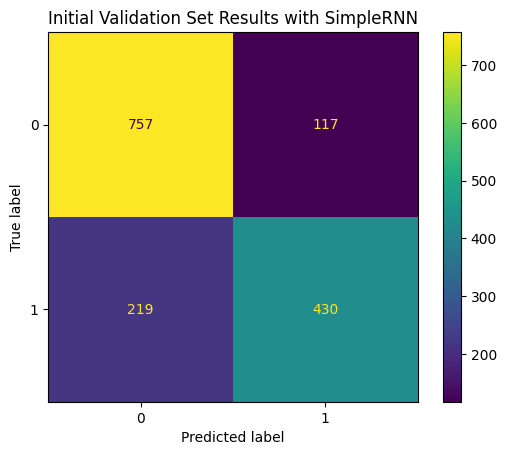

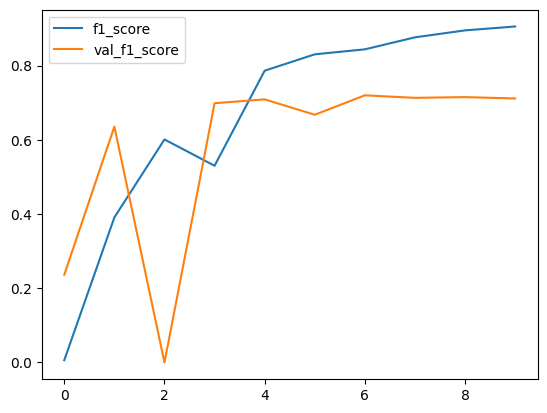

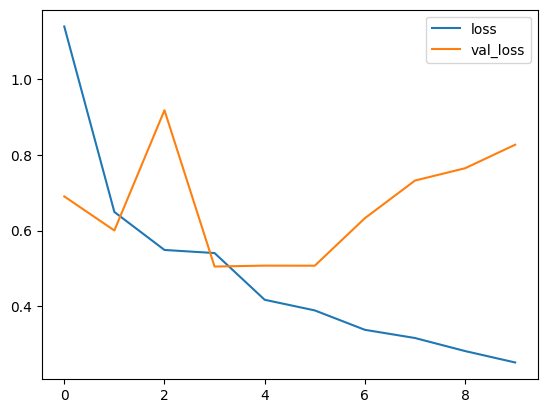

In [16]:
# Initial Results from the first model architecture
val_pred = predict(model, X_val['text'])
cm = confusion_matrix(X_val['target'], val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Initial Validation Set Results with SimpleRNN")
plt.show()
plt.close()
metrics = pd.DataFrame(history.history)
metrics[["f1_score","val_f1_score"]].plot()
plt.show()
plt.close()
metrics[["loss","val_loss"]].plot()
plt.show()
plt.close()

### Try an architecture with LSTM layer

In [17]:
def build_model_with_lstm(encoder):
    # Setup Sequential neural network
    model = models.Sequential(encoder)
    # Add embedding layer
    model.add(layers.Embedding(input_dim=len(encoder.get_vocabulary()), output_dim=64))
    # Add LSTM layer
    model.add(layers.LSTM(128))
    # Add a flatten layer to reduce batch size dimensions
    model.add(layers.Flatten())
    # Add a dense layer with one output
    model.add(layers.Dense(1))
    model.summary()
    return model

def predict(model, data, threshold=0.5):
    y_hat = model.predict(data)
    return y_hat > threshold

In [18]:
VOCAB_SIZE = 5000
# Intitialize encoder with an output mdoe of tf-idf and given vocab size
encoder = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE)
# Set encoding based on train data
encoder.adapt(X_train['text'].to_list())

# Compile model
lstm_model = build_model_with_lstm(encoder)
lstm_model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(1e-4), metrics=['acc', f1_score])
history = lstm_model.fit(X_train['text'], X_train['target'], epochs=10, 
                    validation_data=(X_val['text'], X_val['target']))

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_2 (TextV  (None, None)             0         
 ectorization)                                                   
                                                                 
 embedding_2 (Embedding)     (None, None, 64)          320000    
                                                                 
 lstm (LSTM)                 (None, 128)               98816     
                                                                 
 flatten_2 (Flatten)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 418,945
Trainable params: 418,945
Non-trainable params: 0
________________________________________________

48/48 [==============================] - 1s 11ms/step


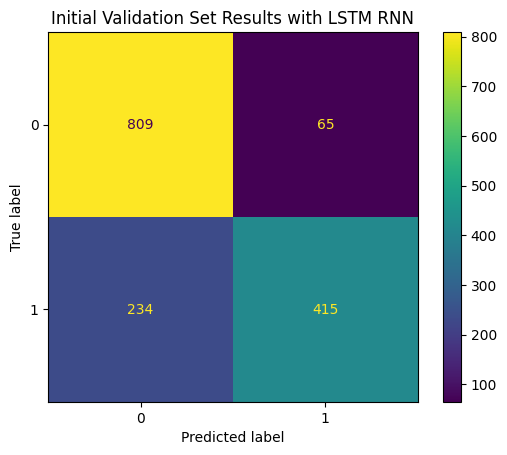

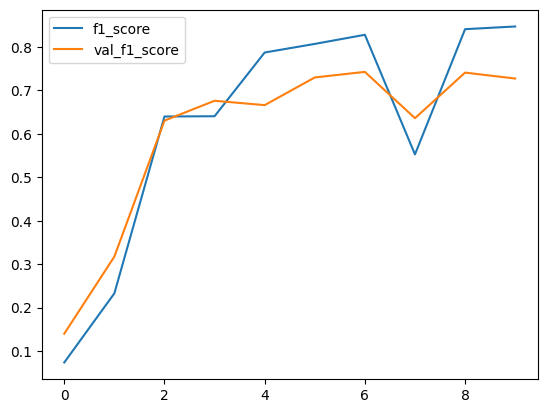

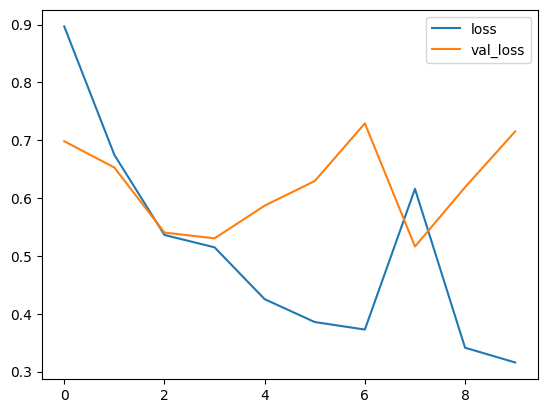

In [19]:
# Initial Results from the second architecture
val_pred = predict(lstm_model, X_val['text'])
cm = confusion_matrix(X_val['target'], val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Initial Validation Set Results with LSTM RNN")
plt.show()
plt.close()
metrics = pd.DataFrame(history.history)
metrics[["f1_score","val_f1_score"]].plot()
plt.show()
plt.close()
metrics[["loss","val_loss"]].plot()
plt.show()
plt.close()

Model with LSTM instead of SimpleRNN layer has similar overfitting to the SimpleRNN model. We should tune learning rates with hyperparameter tuning to try to reduce overfitting with the simpler model.

### Hyperparameter Tuning

Tune vocab sizes in the encoding to ensure that we aren't missing any important words or including too many words with an ill-sized vocabulary set. Tune learning rate to determine if a smaller learning rate can reduce overfitting.

In [24]:
# Learning rate options
learning_rates = [0.000001, 0.00001,0.0001,0.001,0.01]
# Vocab size for encoding
vocab_sizes = [1000, 2000, 3000, 4000, 5000, 6000]

best_val_f1 = 0
best_vocab_size = None
best_lr = None
for vocab_size in vocab_sizes:
    for lr in learning_rates:
        # Intitialize encoder with an output mdoe of tf-idf and given vocab size
        encoder = tf.keras.layers.TextVectorization(max_tokens=vocab_size)
        # Set encoding based on train data
        encoder.adapt(X_train['text'].to_list())
        # Compile model
        model = build_model(encoder)
        model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(lr), metrics=['acc', f1_score])
        # Running Model
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        history = model.fit(X_train['text'], X_train['target'], epochs=10, 
                            validation_data=(X_val['text'], X_val['target']), callbacks=[early_stopping])
        if history.history['val_f1_score'][-1] > best_val_f1:
            best_val_f1 = history.history['val_f1_score'][-1]
            best_lr = lr
            best_vocab_size = vocab_size
print(f"Best Learning Rate: {best_lr}")
print(f"Best Vocab Size: {best_vocab_size}")
print(f"Best F1: {best_val_f1}")

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_5 (TextV  (None, None)             0         
 ectorization)                                                   
                                                                 
 embedding_5 (Embedding)     (None, None, 64)          64000     
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, 128)               24704     
                                                                 
 flatten_5 (Flatten)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 88,833
Trainable params: 88,833
Non-trainable params: 0
__________________________________________________

Method of hyperparameter tuning: Using a nested for loop that iterates through combinations of hyperparameter options, we determine the best model by evaluating the best validation F1 Score. Early stopping may also help reduce overfitting. 

Summary of results:


| Learning Rate | Vocab Size | Val F1 Score |

| 1e-06 | 1000 | 0 |

| 1e-05 | 1000 | 0.1324 |

| 0.0001 | 1000 | 0.7064 |

| 0.001 | 1000 | 0.0273 |

| 0.01 | 1000 | 0.5924 |

| 1e-06 | 2000 | 0 |

| 1e-05 | 2000 | 0.0162 |

| 0.0001 | 2000 | 0.6998 |

| 0.001 | 2000 | 0.7021 |

| 0.01 | 2000 | 0.5924 |

| 1e-06 | 3000 | 0 |

| 1e-05 | 3000 | 0.0499 |

| 0.0001 | 3000 | 0.7243 |

| 0.001 | 3000 | 0 |

| 0.01 | 3000 | 0.5924 |

| 1e-06 | 4000 | 0 |

| 1e-05 | 4000 | 0 |

| 0.0001 | 4000 | 0.7136 |

| 0.001 | 4000 | 0 |

| 0.01 | 4000 | 0 |

| 1e-06 | 5000 | 0 |

| 1e-05 | 5000 | 0 |

**| 0.0001 | 5000 | 0.7363 |**

| 0.001 | 5000 | 0.6751 |

| 0.01 | 5000 | 0 |

| 1e-06 | 6000 | 0 |

| 1e-05 | 6000 | 0 |

| 0.0001 | 6000 | 0.7276 |

| 0.001 | 6000 | 0.7096 |

| 0.01 | 6000 | 0.5924 |


The best learning rate is 0.0001.

The best vocab size is 5000.

We show the best model results below

In [41]:
encoder = tf.keras.layers.TextVectorization(max_tokens=best_vocab_size)
encoder.adapt(X_train['text'].to_list())
best_model = build_model(encoder)
best_model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(best_lr), metrics=['acc', f1_score])
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
best_history = best_model.fit(X_train['text'], X_train['target'], epochs=50, validation_data=(X_val['text'], X_val['target']), callbacks=[early_stopping])

Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_40 (Text  (None, None)             0         
 Vectorization)                                                  
                                                                 
 embedding_40 (Embedding)    (None, None, 64)          320000    
                                                                 
 simple_rnn_39 (SimpleRNN)   (None, 128)               24704     
                                                                 
 flatten_40 (Flatten)        (None, 128)               0         
                                                                 
 dense_40 (Dense)            (None, 1)                 129       
                                                                 
Total params: 344,833
Trainable params: 344,833
Non-trainable params: 0
_______________________________________________

48/48 [==============================] - 0s 5ms/step


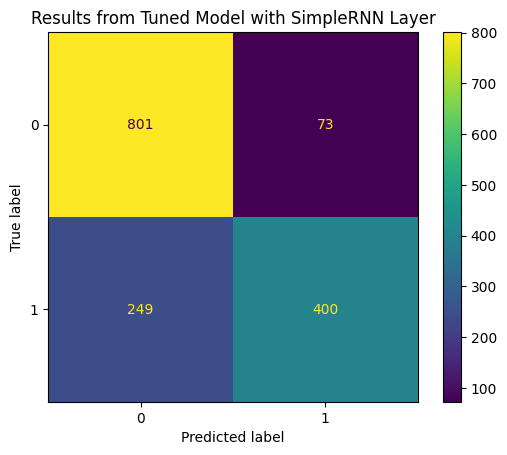

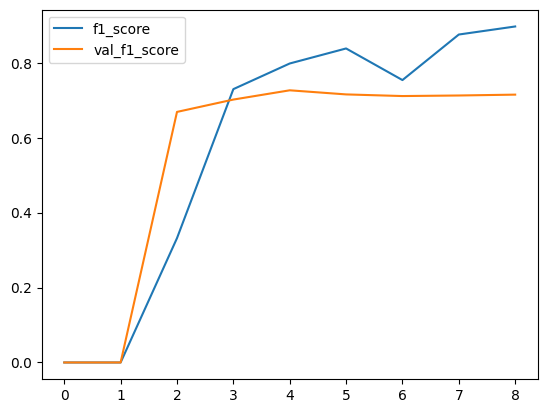

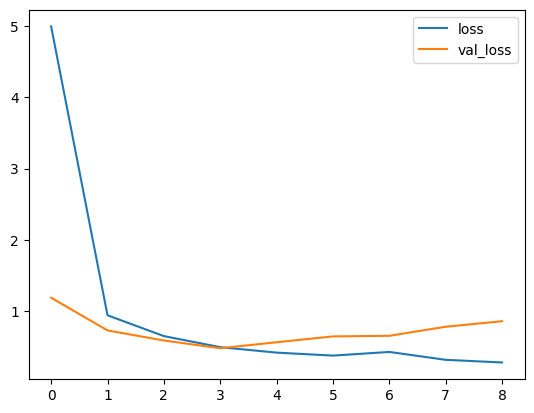

In [42]:
val_pred = predict(best_model, X_val['text'])
cm = confusion_matrix(X_val['target'], val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Results from Tuned Model with SimpleRNN Layer")
plt.show()
plt.close()
metrics = pd.DataFrame(best_history.history)
metrics[["f1_score","val_f1_score"]].plot()
plt.show()
plt.close()
metrics[["loss","val_loss"]].plot()
plt.show()
plt.close()

In [45]:
# Make output submission
raw_test_df['target'] = predict(best_model,remove_links(remove_emojis(raw_test_df['text']))).astype(int)
raw_test_df[['id', 'target']].to_csv("output.csv", index=False)

102/102 [==============================] - 0s 5ms/step


# Conclusion

Recap Summary: I explored the tweet database. I evaluated the occurrences of key words and of locations; however, I did not integrate these into the model structure. Then I used the keras TextVectorization layer to convert the text to numerical data for processing. I started with a simple RNN model with an embedding layer, a SimpleRNN layer, and a Dense layer. This showed signs of overfitting, to see if an LSTM model would yield better results, I built a new model architecture replacing the SimpleRNN layer with an LSTM model layer. This did not yield better results, so I decided to perform hyperparameter tuning on the simpler model. Hyperparameter tuning yielded the optimal vocab size for the encoder and the optimal learning rate for the model.


Key Takeaways: Text vectorization with TF-IDF does not always yield better results than just text embedding with vocab indices.

What went wrong?: There was lots of overfitting in my models. Perhaps this could be improved with a learning rate scheduler. 

Future Improvements: Integrating the keywords and locations into the model to have more features to learn on may help with improving accuracy and F1 score. 